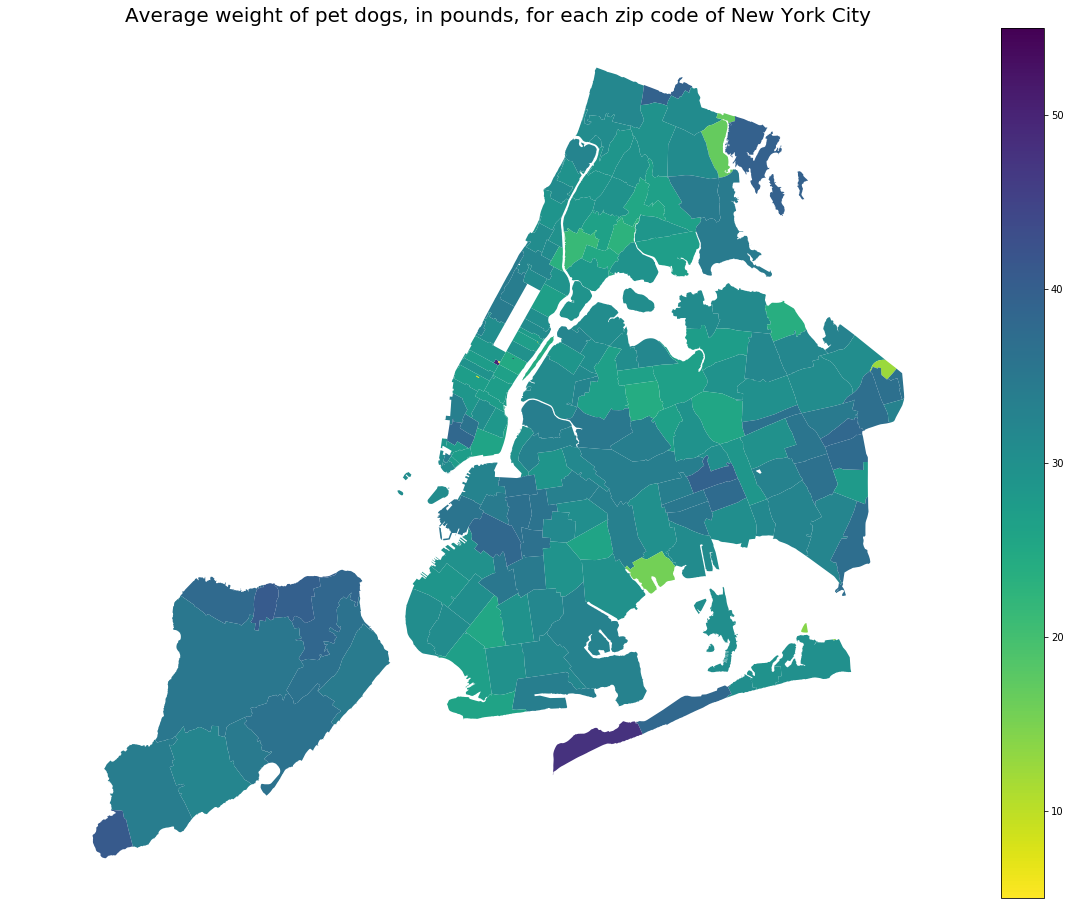

In [262]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import geopandas

### Convert ranges like '7-9 lbs' to 8.0
def range_avg(x):
    if '-' in x:
        s = x.split('-')
        return (int(s[0]) + int(s[1])) / 2
    else:
        return int(x)

### Load the dog weights file into a dataframe
def get_dog_weights():
    df = pd.read_csv('dog_weights.csv')
    df['M'] = df['Average Adult Weight (M)'].str.replace('lbs', '').apply(range_avg)
    df['F'] = df['Average Adult Weight (F)'].str.replace('lbs', '').apply(range_avg)
    df.drop(['Average Adult Weight (M)', 'Average Adult Weight (F)'], axis=1, inplace=True)
    df = df.melt(value_vars=['M', 'F'], id_vars=['Breed'], value_name='Weight', var_name='Gender')
    return df    

### Load the dog registrations file into a dataframe
def get_dog_registrations():
    boroughs = {'Manhattan', 'Bronx', 'Queens', 'Brooklyn', 'Staten Island'}
    # Normalize certain breed names
    breed_map = { 'American Pit Bull Mix / Pit Bull Mix': 'Pitbull',
                  'American Pit Bull Terrier/Pit Bull':   'Pitbull',
                  'Bull Dog, French' :                    'French Bulldog',
                  'Bull Dog, English':                    'Bulldog',
                  'Dachshund':                            'Dachshund (Standard)',
                  'German Shepherd':                      'German Shepherd Dog',
                  'Poodle':                               'Poodle (Standard)',
                  'Poodle, Standard':                     'Poodle (Standard)',
                  'Poodle, Toy':                          'Poodle (Toy)',   
                  'Poodle, Miniature':                    'Poodle (Miniature)',
                  'Schnauzer, Miniature':                 'Miniature Schnauzer',
                  'Welsh Corgi, Cardigan':                'Cardigan Welsh Corgi',
                  'Welsh Corgi, Pembroke':                'Pembroke Welsh Corgi',
                  'Yorkshire Terrier':                    'Yorkshire Terrier (Yorkie)' }
    df = pd.read_csv('NYC_Dog_Licensing_Dataset.csv')
    # Drop all records not in NYC
    df = df[(df['ZipCode'] > 10000) & (df['ZipCode'] <= 11697) & df['Borough'].isin(boroughs)]
    df['ZipCode'] = df['ZipCode'].apply(lambda x: str(x).replace('.0', ''))
    df['BreedName'] = (df['BreedName'].str.strip()
                       .replace(to_replace='\sCrossbreed', value='', regex=True)
                       .replace(breed_map))
    return df

dog_weight_df = get_dog_weights()
dog_reg_df = get_dog_registrations()

### Add weight information to dog registration dataframe
dogs_df = pd.merge(dog_reg_df, dog_weight_df, left_on=['BreedName', 'AnimalGender'], right_on=['Breed', 'Gender'], how='inner')

### Calculate average dog weight per zip code
nyc = geopandas.read_file(r'./nyc_zip/ZIP_CODE_040114.shp')
weight_by_zip = (pd.DataFrame(dogs_df
                              .groupby('ZipCode')['Weight']
                              .agg('mean'))
                 .reset_index())

### Add weight-per-zip data to NYC shape file
weight_data = (pd.merge(nyc, weight_by_zip, right_on='ZipCode', left_on='ZIPCODE', how='inner')
               .dropna())

f, ax = plt.subplots(1, figsize=(20, 16))
ax = weight_data.plot(ax=ax, column='Weight', cmap='viridis_r', legend=True, vmin=5)
ax.set_axis_off()

plt.title('Average weight of pet dogs, in pounds, for each zip code of New York City', fontsize=20)
plt.show()

In [263]:
from scipy import stats

ues_zips = ['10021', '10028', '10044', '10065', '10075', '10128']
ues_dog_avg = dogs_df[dogs_df['ZipCode'].isin(ues_zips)]['Weight'].mean()
ues_percentile = stats.percentileofscore(dogs_df['Weight'], ues_dog_avg)

print("Overall median: {0:.2f}".format(dogs_df['Weight'].median()))
print("Overall mean: {0:.2f}".format(dogs_df['Weight'].mean()))
print("UES mean: {0:.2f}".format(ues_dog_avg))
print("UES percentile: {0:.2f}".format(ues_percentile))
dogs_df['Weight'].describe()

Overall median: 16.00
Overall mean: 31.18
UES mean: 29.33
UES percentile: 64.13


count    94023.000000
mean        31.179578
std         27.764090
min          5.000000
25%          6.500000
50%         16.000000
75%         60.000000
max        182.500000
Name: Weight, dtype: float64

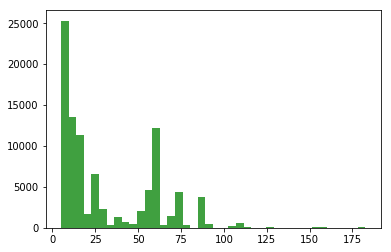

In [265]:
_ = plt.hist(dogs_df['Weight'], 40, facecolor='g', alpha=0.75)